# IC3D generated image error analysis

## Load and transform data

In [1]:
library(tidyverse)
library(broom)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# this csv file is all cells, with 1000 latent space samples per cell

csv_file = "/root/gregj/projects/pytorch_integrated_cell/test_aaegan/aaegan3Dv5_128D_3/struct_model/var_test_testing/all_dat.csv"
df = read_csv(csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  img_index = col_integer(),
  data_provider_index = col_integer(),
  embedding_data_provider_index = col_integer(),
  embedding_train_or_test = col_character(),
  label = col_character(),
  path = col_character(),
  train_or_test = col_character(),
  tot_inten = col_double(),
  tot_inten_recon = col_double(),
  mse_orig = col_double(),
  mse_recon = col_double(),
  bce_orig = col_double(),
  bce_recon = col_double(),
  pearson_orig = col_double(),
  pearson_recon = col_double(),
  corr_orig = col_double(),
  corr_recon = col_double()
)


In [3]:
# remove rows with missing data
df = df[complete.cases(df), ]

# remove empty cols
drop_cols = c("X1", "Unnamed: 0")
df = select(df,-one_of(drop_cols))

# change data types of some cols
df %>%
    mutate(
        train_or_test=as.factor(train_or_test),
        embedding_train_or_test=as.factor(embedding_train_or_test),
        label=as.factor(label)
    ) -> df

In [4]:
# rename cols and move from mse to rmse

df %>%
    rename(
        img_dp_index=data_provider_index,
        latent_dp_index=embedding_data_provider_index,
        latent_phase=embedding_train_or_test,
        img_phase=train_or_test,
        img_path=path,
        img_label=label
    ) %>%
    mutate(rmse_orig=sqrt(mse_orig)) %>%
    mutate(rmse_recon=sqrt(mse_recon)) %>%
    select(-one_of("mse_orig","mse_recon")) ->
    df

In [5]:
# create a master index for the latent inds and a structure label for the latent location

df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    rename(latent_index=img_index,
           latent_dp_index=img_dp_index,
           latent_phase=img_phase,
           latent_label=img_label) %>%
    inner_join(df) ->
    df

Joining, by = c("latent_dp_index", "latent_phase")


In [6]:
# get aggregate stats (median, median absolute deviation) for reconstruction error of each cell

df %>%
    select(img_path,
           img_index,
           img_phase,
           img_dp_index,
           img_label,
           img_phase,
           pearson_orig,
           pearson_recon,
           rmse_orig,
           rmse_recon) %>%
    group_by(img_path, img_index, img_phase, img_dp_index, img_label, img_phase) %>%
    summarise_all(funs(median, mad)) ->
    df_stats

df %>%
    select(img_path, img_index, img_index, img_phase, img_dp_index, tot_inten) %>%
    distinct %>%
    inner_join(df_stats) ->
    df_stats

Joining, by = c("img_path", "img_index", "img_phase", "img_dp_index")


## Join in mitotic annotations

In [39]:
df_alldat_mito = read_csv("alldat_mito.csv")
df_alldat_mito %>% 
    select(path, MitosisLabel) %>%
    inner_join(df_stats, by = c("path" = "img_path")) ->
    df_stats_mito

df_stats_mito$MitosisLabel = as.factor(df_stats_mito$MitosisLabel)
df_stats_mito$BinaryMitosisLabel = as.factor((df_stats_mito$MitosisLabel != 0) + 0)
levels(df_stats_mito$BinaryMitosisLabel) <- c("non-mitotic", "mitotic")

Parsed with column specification:
cols(
  .default = col_character(),
  MitosisLabel = col_integer(),
  Index = col_integer(),
  SegmentationXyPixelSize = col_double(),
  SegmentationZPixelSize = col_double(),
  Version = col_double(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  lightChannel = col_integer(),
  memChannel = col_integer(),
  nucChannel = col_integer(),
  outputThisCellIndex = col_integer(),
  structureChannel = col_integer(),
  timePoint = col_integer()
)
See spec(...) for full column specifications.


## Save out best and worst predictions

In [46]:
N=16

df_stats_mito %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>% top_n(N, pearson_recon_median) ->
    df_best_preds

df_stats_mito %>%
    select(img_index, img_label, img_phase, pearson_recon_median, BinaryMitosisLabel) %>%
    group_by(img_label, img_phase) %>% top_n(N, desc(pearson_recon_median)) ->
    df_worst_preds

In [47]:
df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    inner_join(df_best_preds) -> df_best_preds

df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    inner_join(df_worst_preds) -> df_worst_preds

Joining, by = c("img_index", "img_phase", "img_label")
Joining, by = c("img_index", "img_phase", "img_label")


In [48]:
df_best_preds$Type = "best"
df_worst_preds$Type = "worst"

df_extremal_preds = rbind(df_best_preds, df_worst_preds)

In [49]:
df_best_preds %>% write_csv("best_preds.csv")
df_worst_preds %>% write_csv("worst_preds.csv")
df_extremal_preds %>% write_csv("extremal_preds.csv")

## Plots

Saving 6.67 x 6.67 in image
Warning message:
"Removed 3 rows containing non-finite values (stat_density)."Warning message:
"Removed 3 rows containing non-finite values (stat_density)."

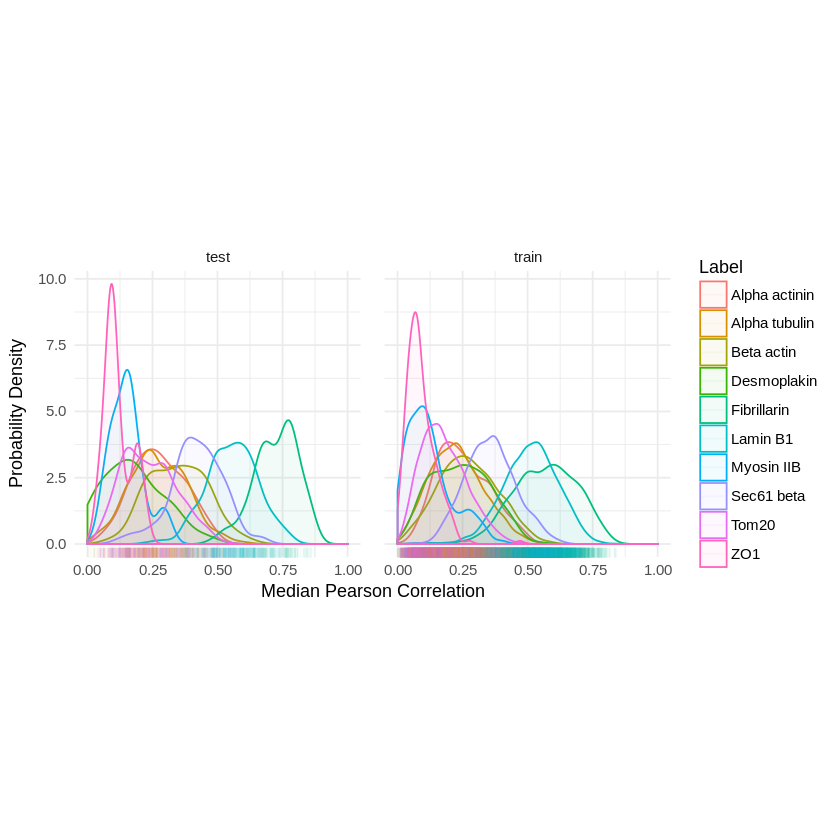

In [30]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~img_phase, scales = 'fixed') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="Median Pearson Correlation", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "pearson_by_class.png", device="png", dpi = 600)
p

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

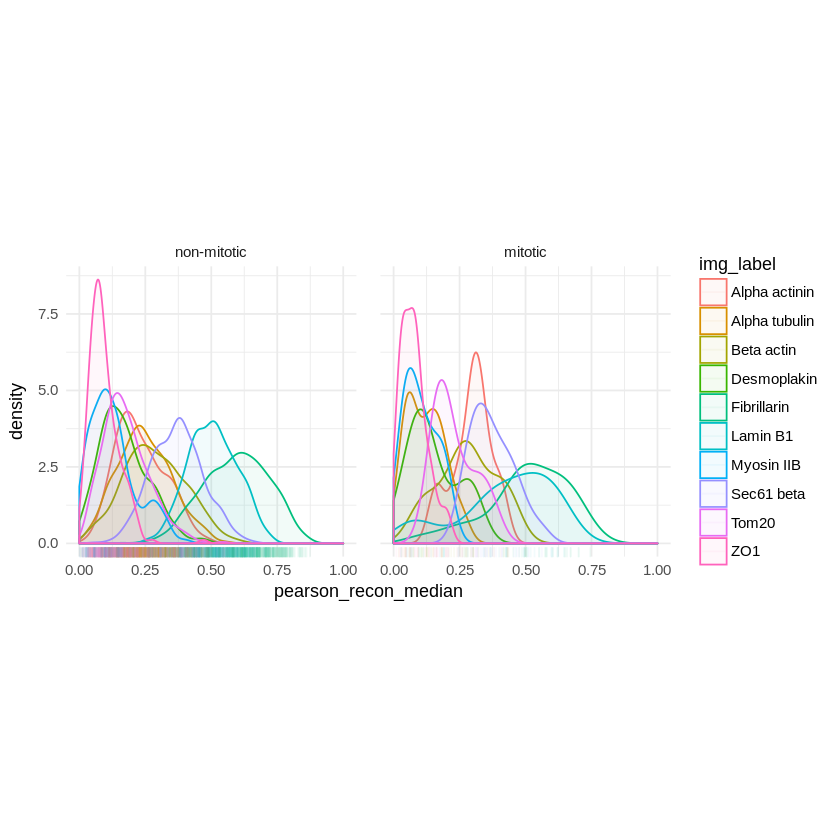

In [28]:
df_stats_mito %>%
    ggplot(aes(x=pearson_recon_median, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~BinaryMitosisLabel, scales = 'fixed') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines"))

Saving 6.67 x 6.67 in image


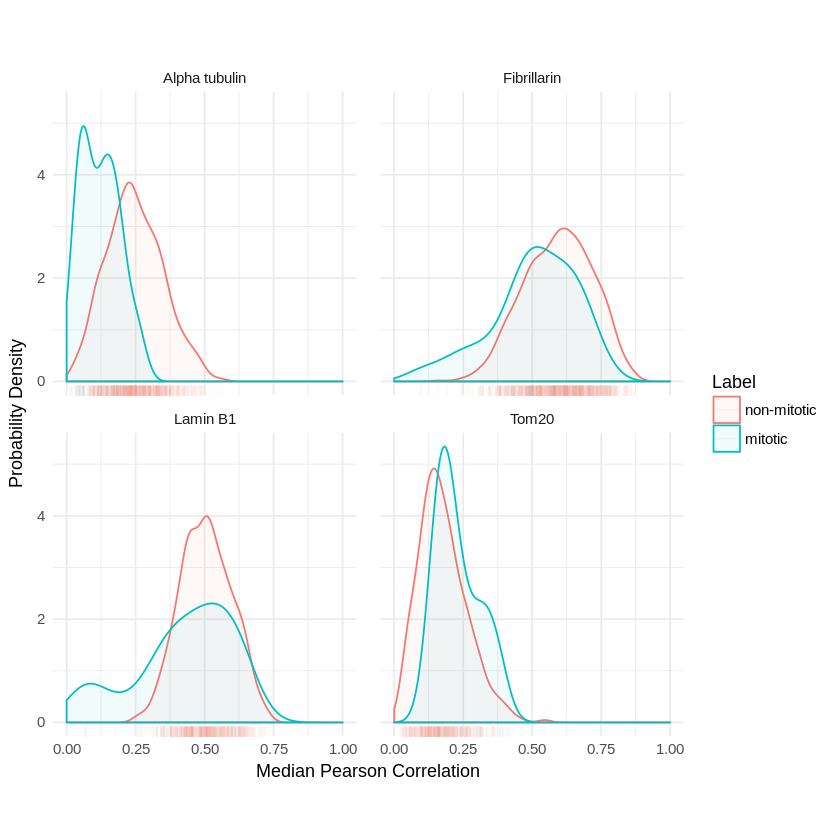

In [27]:
df_stats_mito %>%
    filter(img_label %in% c('Lamin B1', 'Alpha tubulin', 'Tom20', 'Fibrillarin')) ->
    df_stats_mito_filtered

df_stats_mito_filtered %>%
    ggplot(aes(x=pearson_recon_median, color=BinaryMitosisLabel, fill=BinaryMitosisLabel)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    xlim(c(0,1)) +
    facet_wrap(~img_label, scales = 'fixed', ncol=2) +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="Median Pearson Correlation", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "pearson_by_mito_3.png", device="png", dpi = 600)
p

In [23]:
# pval_df = tibble(label = character(0), pvalue = numeric(0))

for (label in levels(df_stats_mito$img_label)) {

    df_stats_mito %>%
        filter(img_label == label) %>%
        select(BinaryMitosisLabel, pearson_recon_median) ->
        df_tmp

    df_tmp %>%
        filter(BinaryMitosisLabel == "mitotic") %>%
        select(pearson_recon_median) ->
        df_x

    df_tmp %>%
        filter(BinaryMitosisLabel != "mitotic") %>%
        select(pearson_recon_median) ->
        df_y

    test_output = ks.test(df_x$pearson_recon_median, df_y$pearson_recon_median)
    print(paste(label, ':',  test_output$p.value))
    
#     df_singlep = tibble(label = label, pvalue = test_output$p.value), )
#     pval_df = rbind(pval_df, c(label,test_output$p.value))
}

[1] "Alpha actinin : 0.0808878242045796"
[1] "Alpha tubulin : 2.29841619514559e-07"
[1] "Beta actin : 0.899932955340789"
[1] "Desmoplakin : 0.637954827286819"
[1] "Fibrillarin : 0.00845714325601554"
[1] "Lamin B1 : 0.0335689180997865"
[1] "Myosin IIB : 0.789143890731203"
[1] "Sec61 beta : 0.935968136167604"
[1] "Tom20 : 0.0159180939576852"
[1] "ZO1 : 0.396867147374781"


## chi-squared test for good vs bad mitotic enrichment

In [152]:
df_extremal_preds$Type = as.factor(df_extremal_preds$Type)

df_pval = data.frame()
for (label in levels(df_extremal_preds$img_label)) {

    df_extremal_preds %>%
        filter(img_label == label) %>%
        select(BinaryMitosisLabel, Type) ->
        df_extremal_preds_tmp

    df_extremal_preds_tmp %>%
        filter(Type=='best') ->
        df_best_tmp
    
    df_extremal_preds_tmp %>%
        filter(Type=='worst') ->
        df_worst_tmp
    
    test_out = chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel,
                          df_extremal_preds_tmp$Type, correct=FALSE) %>%
                          tidy
    
    test_out$label = label
    df_pval = rbind(df_pval,test_out)
    
}

df_pval$p.value.bonf = df_pval$p.value*nrow(df_pval)

Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel, df_extremal_preds_tmp$Type, :
"Chi-squared approxima

In [153]:
df_pval

statistic,p.value,parameter,method,label,p.value.bonf
0.3497268,0.554267836,1,Pearson's Chi-squared test,Alpha actinin,5.54267836
9.1428571,0.002496909,1,Pearson's Chi-squared test,Alpha tubulin,0.02496909
1.0158730,0.313499946,1,Pearson's Chi-squared test,Beta actin,3.13499946
0.3508772,0.553616992,1,Pearson's Chi-squared test,Desmoplakin,5.53616992
4.2666667,0.038867104,1,Pearson's Chi-squared test,Fibrillarin,0.38867104
5.1428571,0.023342202,1,Pearson's Chi-squared test,Lamin B1,0.23342202
0.3497268,0.554267836,1,Pearson's Chi-squared test,Myosin IIB,5.54267836
1.0158730,0.313499946,1,Pearson's Chi-squared test,Sec61 beta,3.13499946
2.0645161,0.150762775,1,Pearson's Chi-squared test,Tom20,1.50762775
0.3497268,0.554267836,1,Pearson's Chi-squared test,ZO1,5.54267836


### weird pearson vs MSE plot

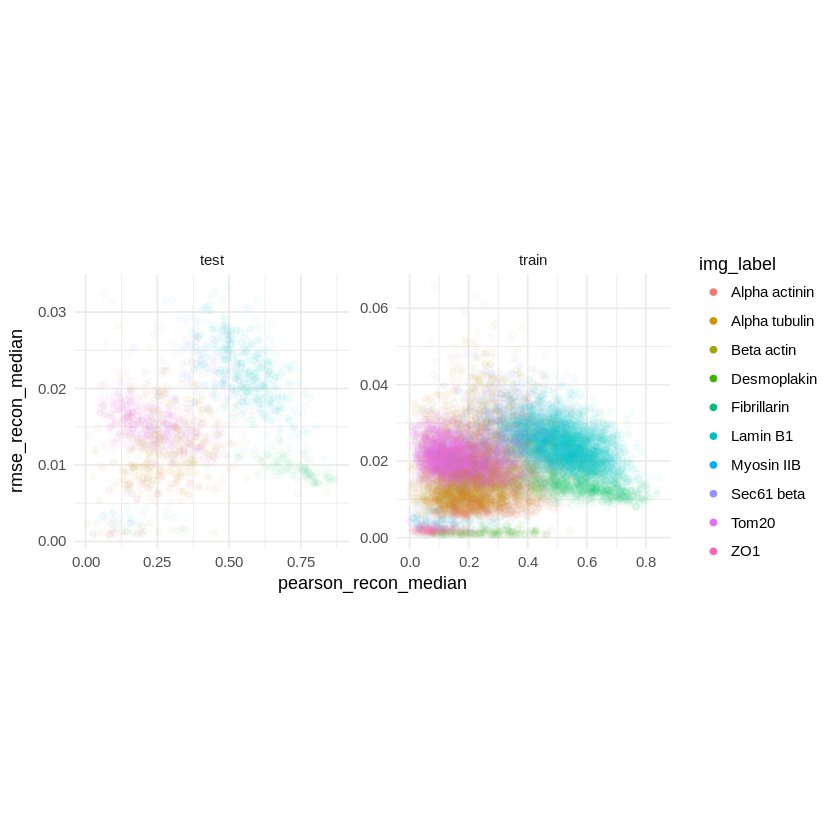

In [17]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, y=rmse_recon_median, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

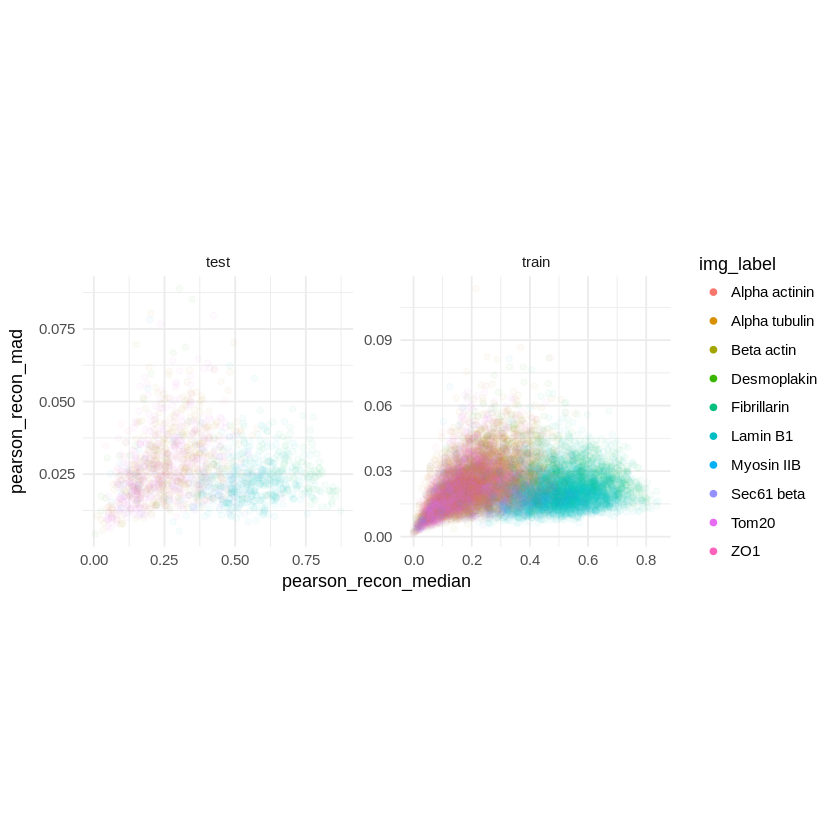

In [18]:
df_stats %>%
    ggplot(aes(x=pearson_recon_median, y=pearson_recon_mad, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

## check recon vs orig

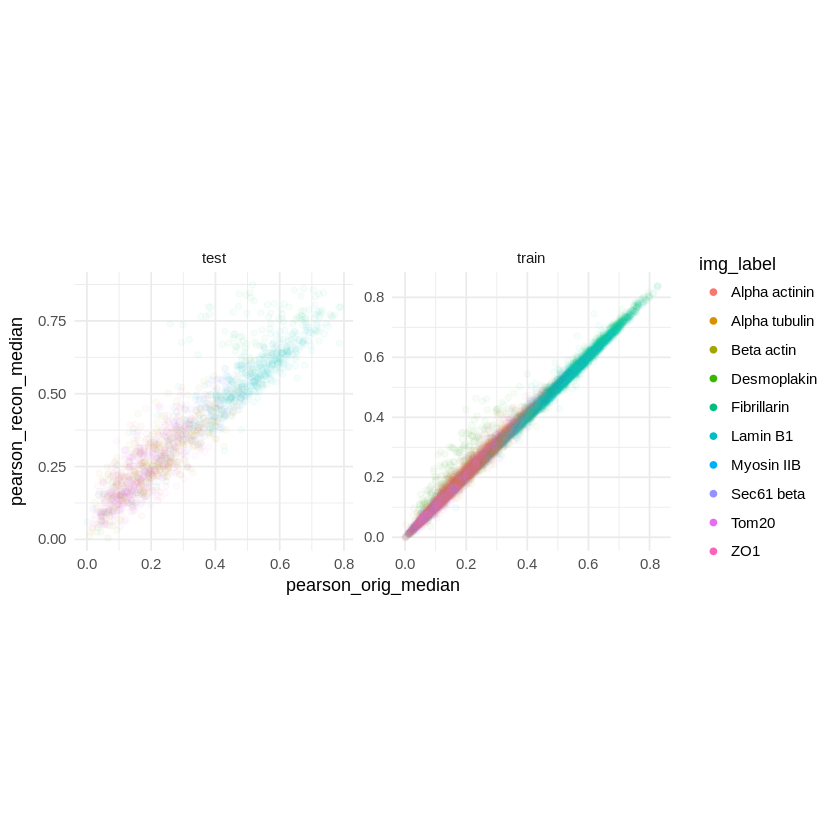

In [19]:
df_stats %>%
    ggplot(aes(x=pearson_orig_median, y=pearson_recon_median, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))